***Install Dependencies***



In [22]:
!pip install -q datasets scikit-learn matplotlib seaborn arabic-reshaper python-bidi


***Imports***

In [ ]:
import re
import json
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

#hardware check - should be cude/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#TextCNN
model_name = "TextCNN-baseline"
print(f"Model Selected: {model_name}")

Using device: cuda
Model Selected: TextCNN-baseline


***Cleaning Function***

In [ ]:
print("Cleaning Function")

def advanced_clean(text):
    text = str(text)
    #remove Tashkeel (Diacritics)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    #remove Tatweel (Elongation)
    text = re.sub(r'ـ', '', text)
    #normalize Alef letter
    text = re.sub(r'[إأآ]', 'ا', text)
    #normalize Taa Marbuta letter
    text = re.sub(r'ة', 'ه', text)
    #normalize Yaa letter
    text = re.sub(r'ى', 'ي', text)
    #remove Numbers
    text = re.sub(r'\d+', '', text)
    #remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    #remove extra Whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

Cleaning Function


***Load Dataset***

In [ ]:
print("⬇ Loading dataset...")
dataset = load_dataset("omkarthawakar/FannOrFlop")

#only keep needed columns
df = dataset["train"].to_pandas()[["poem_verses", "era"]].dropna()

print("Applying Advanced Cleaning...")
print("Before:", df["poem_verses"].iloc[0][:80])
df["poem_verses"] = df["poem_verses"].apply(advanced_clean)
print("After :", df["poem_verses"].iloc[0][:80])

df.head()


⬇ Loading dataset...
Applying Advanced Cleaning...
Before: 1

حَيّـاكُمُ اللَـهُ أَحيـوا العِلمَ وَالأَدَبا

إِن تَنشُروا العِلمَ يَنشُر في
After : حياكم اللةاحيوا العلم والادبا ان تنشروا العلم ينشر فيكم العربا ولا حياة لكم الا 


,poem_verses,era
0,حياكم اللةاحيوا العلم والادبا ان تنشروا العلم ...,العصر الحديث
1,غاب الاديب اديب مصر واختفى فلتبكةالاقلام او تت...,العصر الحديث
2,عثمان انك قد اتيت موفقا شروى سميك جامع التنزيل...,العصر الحديث
3,ان عضيك يا اخىبالملام لا يؤدىلمثل هذا الخصام ا...,العصر الحديث
4,من واجد منقر المنام طريد دهر جائر الاحكام مشتت...,العصر الحديث


***Split & Encode Labels***



In [ ]:
#encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["era"])

label2id = {label: idx for idx, label in enumerate(le.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

print("Classes:", list(le.classes_))

#stratified split
train_df, val_df = train_test_split(
    df,
    test_size= 0.2, #this goes to val_df
    stratify = df["label"], #ensure class distribution is preserved
    random_state = 42, #stability so every time we run code we get same split
)

print(f"Train size: {len(train_df)}")
print(f"Val size : {len(val_df)}")

train_df["label"].value_counts()

Classes: ['الدولة الايوبية', 'الدولة الفاطمية', 'الدولة المملوكية', 'الشعراء المخضرمون', 'العصر الأموي', 'العصر الإسلامي', 'العصر الحديث', 'العصر العباسي', 'العصر العثماني', 'المغرب والأندلس', 'عصر بين الدولتين', 'قبل الإسلام']
Train size: 5587
Val size : 1397


label
7     1874
6      560
4      454
9      357
0      330
1      327
2      326
3      307
11     299
8      261
10     257
5      235
Name: count, dtype: int64

***Balance Data (Upsampling)***

In [ ]:
print("Balancing training data...")
#to make all class of equal sizes
max_size = train_df["label"].value_counts().max()#counting samples in each class
balanced_parts = []

for label_id in train_df["label"].unique(): #looping over each class
    subset = train_df[train_df["label"] == label_id]
    upsampled = resample(
        subset,
        replace = True,
        n_samples = max_size,
        random_state = SEED,
    )
    balanced_parts.append(upsampled)

train_df_balanced = pd.concat(balanced_parts)
train_df_balanced = (
    train_df_balanced.sample(frac = 1, random_state = SEED)
    .reset_index(drop = True)
)

print("Balanced train size:", len(train_df_balanced))
train_df_balanced["label"].value_counts()


Balancing training data...
Balanced train size: 22488


label
0     1874
5     1874
9     1874
10    1874
2     1874
4     1874
8     1874
3     1874
6     1874
11    1874
7     1874
1     1874
Name: count, dtype: int64

***Tokenization***

In [ ]:
print("Building vocabulary for TextCNN...")

def simple_tokenize(text):
    #whitespace tokenization
    return text.split()

#build word frequency from balanced training only
counter = Counter()
for txt in train_df_balanced["poem_verses"]:
    counter.update(simple_tokenize(txt))

min_freq = 2  #ignore extremely rare words (words appear once)
#special tokens - <PAD> to pad short poems to a fixed length
#and <UNK> used when validation set contains unseen words
special_tokens = ["<pad>", "<unk>"]

vocab = list(special_tokens)
for word, freq in counter.items():
    if freq >= min_freq:
        vocab.append(word)

stoi = {w: i for i, w in enumerate(vocab)}
itos = {i: w for w, i in stoi.items()}

vocab_size = len(stoi)
print(f"Vocab size: {vocab_size} (min_freq={min_freq})")


Building vocabulary for TextCNN...
Vocab size: 166123 (min_freq=2)


In [ ]:
MAX_LEN = 128
print("Using MAX_LEN:", MAX_LEN)

def encode_text(text, stoi, max_len):
    tokens = simple_tokenize(text)
    ids = [stoi.get(tok, stoi["<unk>"]) for tok in tokens[:max_len]]
    if len(ids) < max_len:
        ids = ids + [stoi["<pad>"]] * (max_len - len(ids))

    return ids

print("Encoding train and validation texts...")

train_df_balanced["input_ids"] = train_df_balanced["poem_verses"].apply(
    lambda t: encode_text(t, stoi, MAX_LEN)
)
val_df["input_ids"] = val_df["poem_verses"].apply(
    lambda t: encode_text(t, stoi, MAX_LEN)
)

train_df_balanced[["poem_verses", "input_ids"]].head()


Using MAX_LEN: 128
Encoding train and validation texts...


,poem_verses,input_ids
0,قل لصديقىابىعلي ما هكذا يفعل الصديق اتيت ما لم...,"[2, 3, 4, 5, 6, 7, 8, 4, 9, 10, 11, 12, 13, 14..."
1,لاقوا غداة الروع ضموزة فيها السنور من بنىفهر م...,"[110, 111, 112, 113, 114, 115, 78, 116, 117, 1..."
2,لا والذىتجلى الكروب بةوتنفرج الخطوب لابت الا ب...,"[65, 134, 135, 136, 137, 138, 107, 139, 140, 1..."
3,تجاللت عن فهر وعن جارتىفهر وودعت نعمى بالسلام ...,"[169, 63, 170, 171, 172, 173, 174, 175, 176, 1..."
4,قلوا لديك فاخطاوا لما دعوت فابطاوا وتبرعوا حتى...,"[787, 788, 789, 413, 790, 791, 792, 276, 793, ..."


**PyTorch Dataset & DataLoader**

In [ ]:
print("Creating PyTorch Dataset and DataLoader...")

#our custom dataset class
class PoetryDataset(Dataset):
    #constructor
    def __init__(self, df):
        self.X = np.stack(df["input_ids"].values)
        self.y = df["label"].values.astype(np.int64)

    def __len__(self):
        return len(self.y)
    #fetching one sample
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

#creatinf dataset object - one for train and one for val
train_dataset = PoetryDataset(train_df_balanced) #balanced
val_dataset = PoetryDataset(val_df) #original distribution of data

BATCH_SIZE = 32

#creating DataLoader - shuffling train only
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,   
    drop_last= False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size = 64,
    shuffle = False,
    drop_last = False,
)

len(train_dataset), len(val_dataset)


Creating PyTorch Dataset and DataLoader...


(22488, 1397)

***Initialize Model***

In [ ]:
print("Initialize Model")

#our class
class TextCNNClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_classes,
        filter_sizes = (3, 4, 5), #CNN kernel, it captures 3-gram 4gram 5-gram
        num_filters = 128, #feature maps - number of filters per kernel size
        dropout = 0.5, #used for regularization to prevent overfitting
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi["<pad>"])

        #filter sizes are 3,4 and 5 so we have 3 Conv1d layers
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels = embed_dim,
                    out_channels = num_filters,
                    kernel_size = k,
                )
                for k in filter_sizes #creates 3 convolutional layers
            ]
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
    
    #forward pass
    def forward(self, x):
        #x shape is [Batch_size, MAX_LEN]
        emb = self.embedding(x) #emb [Batch_size, MAX_LEN, embed_dim]
        emb = emb.transpose(1, 2) #emb [Batch_size, embed_dim, MAX_LEN] as Conv1D expect it this way
        conv_outputs = []
        for conv in self.convs:
            c = conv(emb)
            c = torch.relu(c) #keeps + remove -
            pooled = torch.max(c, dim = 2).values #max pooling
            conv_outputs.append(pooled)

        h_cat = torch.cat(conv_outputs, dim = 1) #concatenate 3 filters sizes
        h_cat = self.dropout(h_cat)
        logits = self.fc(h_cat) #logits will be fed to Cross Entropy Loss
        return logits

num_classes = len(le.classes_)

model = TextCNNClassifier(
    vocab_size = vocab_size,
    embed_dim = 128,
    num_classes = num_classes,
    filter_sizes = (3, 4, 5),
    num_filters = 128,
    dropout = 0.5,
).to(device)

print(model)


Initialize Model
TextCNNClassifier(
  (embedding): Embedding(166123, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=384, out_features=12, bias=True)
)


***Training Setup***

In [ ]:
print("Training Setup")

criterion = nn.CrossEntropyLoss() #loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) #optimizer and learning rate

EPOCHS = 10

#used for validation
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * y_batch.size(0)

            #prediction is in shape of (samples, 12) and converted to argmax(axis=1)
            #which means selecting class with highest score
            preds = torch.argmax(logits, dim = 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average = "weighted")

    return avg_loss, acc, f1, np.array(all_labels), np.array(all_preds)


Training Setup


***Train Model***

In [ ]:
print("Train Model")

best_val_acc = 0.0 #tracking highest validation accuracy
best_state_dict = None #storing weights for best epoch

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        #backpropagation
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * y_batch.size(0)

    train_loss /= len(train_loader.dataset)

    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val F1: {val_f1:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with Val Acc = {best_val_acc:.4f}")


Train Model
Epoch 01/10 | Train Loss: 2.0024 | Val Loss: 3.1579 | Val Acc: 0.3364 | Val F1: 0.1713
Epoch 02/10 | Train Loss: 1.0841 | Val Loss: 3.9698 | Val Acc: 0.3422 | Val F1: 0.1863
Epoch 03/10 | Train Loss: 0.5996 | Val Loss: 4.1987 | Val Acc: 0.3400 | Val F1: 0.1791
Epoch 04/10 | Train Loss: 0.3395 | Val Loss: 4.0279 | Val Acc: 0.3608 | Val F1: 0.2229
Epoch 05/10 | Train Loss: 0.2018 | Val Loss: 4.4044 | Val Acc: 0.3565 | Val F1: 0.2135
Epoch 06/10 | Train Loss: 0.1288 | Val Loss: 4.5060 | Val Acc: 0.3565 | Val F1: 0.2139
Epoch 07/10 | Train Loss: 0.0857 | Val Loss: 4.7975 | Val Acc: 0.3658 | Val F1: 0.2302
Epoch 08/10 | Train Loss: 0.0589 | Val Loss: 5.5079 | Val Acc: 0.3644 | Val F1: 0.2283
Epoch 09/10 | Train Loss: 0.0494 | Val Loss: 6.4038 | Val Acc: 0.3615 | Val F1: 0.2215
Epoch 10/10 | Train Loss: 0.0429 | Val Loss: 6.9497 | Val Acc: 0.3629 | Val F1: 0.2279

Loaded best model with Val Acc = 0.3658


***Evaluate and Visualize***


Final Report :
Accuracy: 0.363, F1 (weighted): 0.228

                   precision    recall  f1-score   support

  الدولة الايوبية      0.500     0.012     0.024        83
  الدولة الفاطمية      1.000     0.012     0.024        82
 الدولة المملوكية      0.000     0.000     0.000        82
الشعراء المخضرمون      1.000     0.039     0.076        76
     العصر الأموي      0.467     0.061     0.109       114
   العصر الإسلامي      1.000     0.017     0.033        59
     العصر الحديث      0.532     0.179     0.267       140
    العصر العباسي      0.350     0.985     0.517       468
   العصر العثماني      1.000     0.031     0.060        65
  المغرب والأندلس      0.714     0.056     0.104        89
 عصر بين الدولتين      0.000     0.000     0.000        64
      قبل الإسلام      0.500     0.013     0.026        75

         accuracy                          0.363      1397
        macro avg      0.589     0.117     0.103      1397
     weighted avg      0.513     0.363     0.228      1397

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


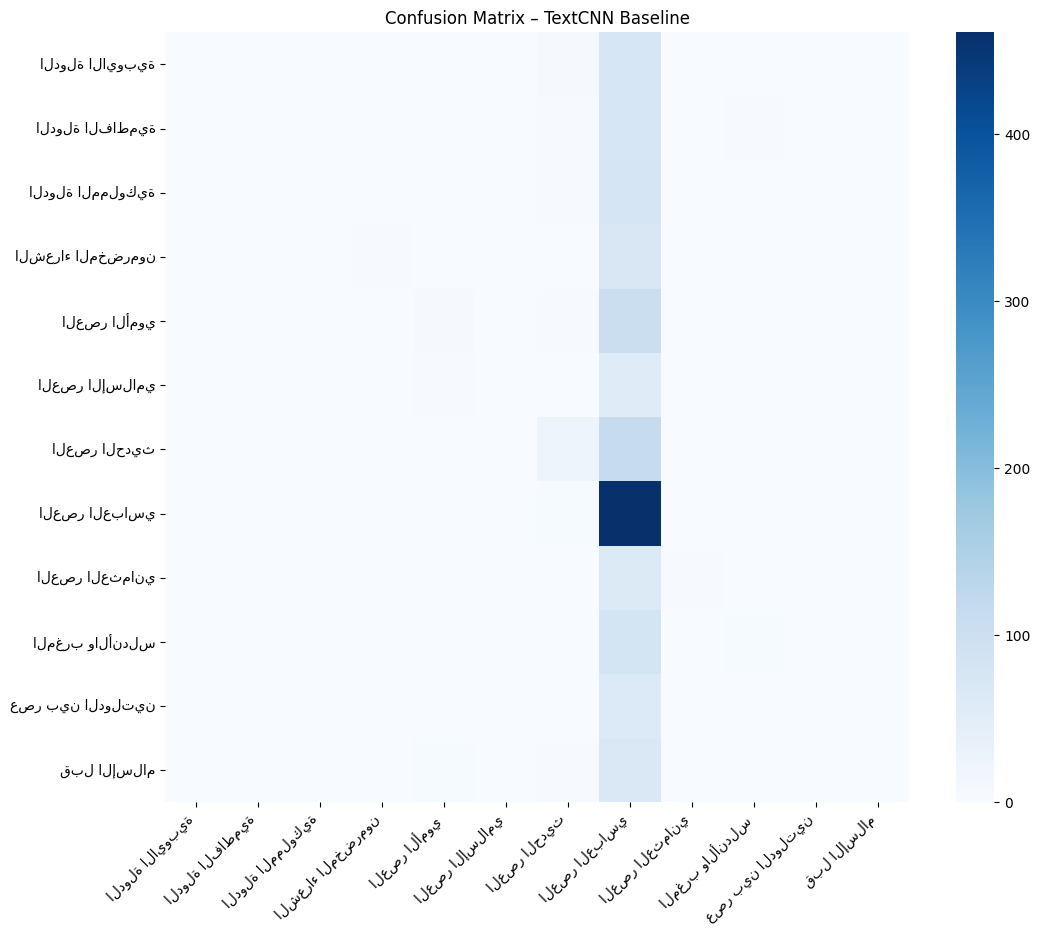

In [ ]:
print("\nFinal Report :")

val_loss, val_acc, val_f1, y_true, y_pred = evaluate(model, val_loader)
print(f"Accuracy: {val_acc:.3f}, F1 (weighted): {val_f1:.3f}\n")

#printing text report
print(classification_report(y_true, y_pred, target_names = le.classes_, digits = 3))

#visualizing Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot = False,
    cmap = "Blues",
    xticklabels = le.classes_,
    yticklabels = le.classes_,
)
plt.title("Confusion Matrix – TextCNN Baseline")
plt.xticks(rotation = 45, ha = "right")
plt.yticks(rotation = 0)
plt.show()


***Save Model and Tokenizer***

In [ ]:
import os

save_dir = "./textcnn_poetry_baseline"
print(f"Saving model to {save_dir} ...")

os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, "textcnn_weights.pt"))

with open(os.path.join(save_dir, "stoi.json"), "w", encoding = "utf-8") as f:
    json.dump(stoi, f, ensure_ascii = False)

with open(os.path.join(save_dir, "label_classes.json"), "w", encoding = "utf-8") as f:
    json.dump(list(le.classes_), f, ensure_ascii = False)

print("Done.")


Saving model to ./textcnn_poetry_baseline ...
Done.
